# Advanced handling and aggregation

Further reading for long evenings:
* https://github.com/alanderex/pydata-pandas-workshop/tree/master/notebooks
* https://github.com/TomAugspurger/pandas-head-to-tail/blob/master/notebooks/03-Iterators-Groupby.ipynb
* https://realpython.com/pandas-groupby/

In [ ]:
import pandas as pd
%matplotlib inline

## Group data analysis
One of the basic procedures in data analysis is to divide the data into *groups*, apply some operation to individual groups and finally combine the results into a suitable dataset. In English, you can commonly find it as *split-apply-combine*. Groups are often, though not necessarily, defined by some (categorical) variable, eg. it could be color, gender or continent. However, groups can also be created by derivation, eg. using a range or time series properties. We've actually seen both in previous EDA lessons, creating groups for rainy days or individual years.

Let's explain it practically. We will use a nice dataset with data from the US Congress, which contains a list of all the men and women who have ever sat in one of its chambers (House or Senate).

In [ ]:
# link directly to the csv file on the internet (magic :) )
LEGISLATORS_HISTORICAL_URL_CSV = (
    "https://theunitedstates.io/congress-legislators/legislators-historical.csv"
)

In [ ]:
legislators_historical = pd.read_csv(
    LEGISLATORS_HISTORICAL_URL_CSV,
    usecols=["gender", "type", "state", "party", "birthday", "first_name", "last_name"],
    parse_dates=["birthday"],
)

In [ ]:
legislators_historical

,last_name,first_name,birthday,gender,type,state,party
0,Bassett,Richard,1745-04-02,M,sen,DE,Anti-Administration
1,Bland,Theodorick,1742-03-21,M,rep,VA,NaN
2,Burke,Aedanus,1743-06-16,M,rep,SC,NaN
3,Carroll,Daniel,1730-07-22,M,rep,MD,NaN
4,Clymer,George,1739-03-16,M,rep,PA,NaN
...,...,...,...,...,...,...,...
12050,Hagedorn,Jim,1962-08-04,M,rep,MN,Republican
12051,Young,Don,1933-06-09,M,rep,AK,Republican
12052,Fortenberry,Jeff,1960-12-27,M,rep,NE,Republican
12053,Vela,Filemon,1963-02-13,M,rep,TX,Democrat


### Step 1: Split
The [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html?highlight=groupby#pandas.DataFrame.groupby ) method is used to divide data into groups. The simplest and perhaps also the most common usage is to group by an existing column in a table. According to `type`, ie. in our dataset according to the chamber (type): ` rep` is the House of Representatives, `sen` is the Senate.

In [ ]:
legislators_historical_by_type = legislators_historical.groupby("type")
legislators_historical_by_type

We received an object of type [`GroupBy`](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html). If it reminds you of `DatetimeIndexResampler` from previous lesson, it is a very good association. This operation only divided the data into groups, but we have not yet said what we want to do with those groups.

### Step 2 + 3: Apply + Combine
We can now apply an operation to the groups we created with `groupby`. This is the *apply* step. It is not worth it for us to separate this step from the third step *combine*, because if we already apply an operation, we would like to compile the result into the resulting dataset. Moreover, Pandas itself does not separate these steps in any way.

* Note: Apply and combine will become more separate in large data processing tools, which no longer fit comfortably in the computer's operating memory and pandas are no longer enough for them. Apply then takes place in parts, even if distributed on separate servers, and the resulting combine is done by collecting partial results.

We will now use the simple aggregation method `count`, which returns the number of values (in groups, of course).

In [ ]:
legislators_historical_by_type.count()

,last_name,first_name,birthday,gender,state,party
type,,,,,,
rep,10215,10215,9725,10215,10215,9991
sen,1840,1840,1780,1840,1840,1832


We see that 1830 senators and 10151 congressmen are recorded in the data. On the left side of the index, we see the groups according to which the dataset was aggregated and all columns to which our aggregation function could be applied (in this case to all the remaining ones).
From the numbers, you may notice that some values from date of birth and party is missing.
Before applying the *apply* step, we can choose which of the columns to do so, making the output a little clearer. If we choose only one column, we get Series instead of DataFrame.

In [ ]:
legislators_historical_by_type['party'].count()

type
rep    9991
sen    1832
Name: party, dtype: int64

We can simplify this step a bit - rather than using the `count` above one column within the aggregation, we can use the *size* of each of the groups.

In [ ]:
legislators_historical_by_type.size()

type
rep    10215
sen     1840
dtype: int64

**Task:** 

Divide the data by party (`party`) and list the number of records in each group. Can you sort the result by group size?

You may have noticed the index of the result. If not, it doesn't matter, you will notice now :) . We will try to create groups not from one column, but from two. Let"s divide the legislators by state, and each group for one state still by gender.

In [ ]:
legislators_by_state_gender_counts = legislators_historical.groupby(["state", "gender"]).count()
legislators_by_state_gender_counts

last_name  first_name  birthday  type  party
state gender                                              
AK    M              17          17        17    17     15
AL    F               4           4         4     4      4
      M             205         205       196   205    205
AR    F               5           5         5     5      5
      M             112         112       109   112    110
...                 ...         ...       ...   ...    ...
WI    M             198         198       198   198    198
WV    F               1           1         1     1      1
      M             119         119       117   119    119
WY    F               1           1         1     1      1
      M              39          39        39    39     39

[105 rows x 5 columns]

So we have groups that are defined by a pair of state and gender values (`state`,` gender`). And that's exactly why in Pandas [`MultiIndex`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) exists.

### Working with MultiIndex
The properties of a MultiIndex, actually such a multilevel or multidimensional index, can be explored (apart from a simple display) using several useful attributes.

In [ ]:
# number of levels
legislators_by_state_gender_counts.index.nlevels

2

In [ ]:
# level names
legislators_by_state_gender_counts.index.names

FrozenList(['state', 'gender'])

In [ ]:
# power (number of values) of individual levels
legislators_by_state_gender_counts.index.levshape

(58, 2)

In [ ]:
# values in each level
legislators_by_state_gender_counts.index.levels

FrozenList([['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'DK', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OL', 'OR', 'PA', 'PI', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'], ['F', 'M']])

So we know that our (multi)index has two levels. In order to get a specific line, we must enter two values. We will use `tuple` for this (attention, it must really be` tuple` and not `list`, ie we must use round brackets and not square brackets).

In [ ]:
legislators_by_state_gender_counts.loc[("WY", "F")]

last_name     1
first_name    1
birthday      1
type          1
party         1
Name: (WY, F), dtype: int64

What if we entered only half of the index? We get the whole group, in our case the whole state.

In [ ]:
legislators_by_state_gender_counts.loc["WY"]

,last_name,first_name,birthday,type,party
gender,,,,,
F,1,1,1,1,1
M,39,39,39,39,39


**Question:** What is the index of the resulting table?

If we want one gender, we can change the index order.

In [ ]:
swapped_index = legislators_by_state_gender_counts.index.swaplevel(0, 1)
legislators_by_gender_state_counts = legislators_by_state_gender_counts.set_index(swapped_index)
legislators_by_gender_state_counts

last_name  first_name  birthday  type  party
gender state                                              
M      AK            17          17        17    17     15
F      AL             4           4         4     4      4
M      AL           205         205       196   205    205
F      AR             5           5         5     5      5
M      AR           112         112       109   112    110
...                 ...         ...       ...   ...    ...
       WI           198         198       198   198    198
F      WV             1           1         1     1      1
M      WV           119         119       117   119    119
F      WY             1           1         1     1      1
M      WY            39          39        39    39     39

[105 rows x 5 columns]

In [ ]:
legislators_by_gender_state_counts.loc["F"].head()

,last_name,first_name,birthday,type,party
state,,,,,
AL,4,4,4,4,4
AR,5,5,5,5,5
AZ,4,4,4,4,4
CA,26,26,26,26,26
CO,3,3,3,3,3


You can find more about (advanced) working with indexes and multi-indexes in the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).
If we want to "get rid of" the multiindex, we can do it with `.reset_index()` function

In [ ]:
legislators_by_state_gender_counts.reset_index().head(5)

,state,gender,last_name,first_name,birthday,type,party
0,AK,M,17,17,17,17,15
1,AL,F,4,4,4,4,4
2,AL,M,205,205,196,205,205
3,AR,F,5,5,5,5,5
4,AR,M,112,112,109,112,110


Or use `groupby` with `as_index = False` directly.

In [ ]:
legislators_historical.groupby(["state", "gender"], as_index=False).count().head(5)

,state,gender,last_name,first_name,birthday,type,party
0,AK,M,17,17,17,17,15
1,AL,F,4,4,4,4,4
2,AL,M,205,205,196,205,205
3,AR,F,5,5,5,5,5
4,AR,M,112,112,109,112,110


## What is the `DataFrameGroupBy` object?
At the beginning we did a basic aggregation without applying functions and we got some kind of object. Is it possible to do something with it without aggregating? It turns out that yes.

Before we get to that, let's try one **task**: 
Divide our dataframe by party - ie. create a dataframe for each party and save it to a separate file. E.g. `Democrat` will go to Democrat.csv etc.

In [ ]:
legislators_historical.groupby('party')

One key function that this object offers us is iteration.

In [ ]:
groups = legislators_historical.groupby('party')

next(iter(groups)) # this will get the first element during the iteration (for loop)

('Adams',
       last_name first_name   birthday gender type state  party
 994       Mills     Elijah 1776-12-01      M  sen    MA  Adams
 1079      Lloyd      James        NaT      M  sen    MA  Adams
 1122  McIlvaine     Joseph 1769-10-02      M  sen    NJ  Adams
 1145     Thomas      Jesse        NaT      M  sen    IL  Adams
 1152   Van Dyke   Nicholas 1770-12-20      M  sen    DE  Adams
 ...         ...        ...        ...    ...  ...   ...    ...
 1398     Holmes       John 1773-03-14      M  sen    ME  Adams
 1429    Silsbee  Nathaniel 1773-01-14      M  sen    MA  Adams
 1472   Chambers    Ezekiel 1788-02-28      M  sen    MD  Adams
 1501  Hendricks    William 1782-11-12      M  sen    IN  Adams
 2033   Harrison    William 1773-02-09      M  sen    OH  Adams
 
 [100 rows x 7 columns])

What can it be for us? When aggregating, data is drastically simplified and we are not always sure that our aggregations are written correctly. Using iteration over groups, we can display all data before next steps of aggregation.

In [ ]:
for party, df in legislators_historical.groupby('party'):
    df.to_csv(party + '.csv')

You probably won't appreciate this functionality as much when it's just one column, here `party`, so the alternative is not that complicated. But once you start aggregating over multiple columns, iterations become more and more useful.

## Other aggregation functions
So far we have only aggregated using `.size` or `.count`, but there are many other aggregation methods, especially numeric ones.
To make it easier to work with aggregations, we will use the `.agg` method, which accepts a dictionary. This dictionary specifies *what* we want to aggregate (key) and *how* we want to aggregate (value). With the fact that the aggregation methods for one column can be multiple at once. We'll see this in a moment.

In [ ]:
legislators_historical.groupby('state').agg({'birthday': 'max'}).head()

,birthday
state,
AK,1962-03-30
AL,1976-07-27
AR,1968-08-21
AS,1943-08-15
AZ,1976-11-03


In [ ]:
legislators_historical.groupby('state').agg({
    'birthday': ['min', 'max'],
    'party': 'nunique'}
).head()

birthday              party
             min        max nunique
state                              
AK    1848-09-17 1962-03-30       3
AL    1780-01-30 1976-07-27       8
AR    1788-08-25 1968-08-21       5
AS    1937-03-13 1943-08-15       1
AZ    1816-01-24 1976-11-03       3

## Column transformation
Most of the time we worked with the data we read from the file and apart from some basic cleaning we did not change it in any way. Now we will show how to do some basic transformations.

For example, we may be interested in what values we have or do not have in a given column. To obtain such information, use the `.isnull` and `.notnull` methods, which are inverse to each other.

In [ ]:
legislators_historical['party'].isnull()

0        False
1         True
2         True
3         True
4         True
         ...  
12050    False
12051    False
12052    False
12053    False
12054    False
Name: party, Length: 12055, dtype: bool

Series has a `isnull` method that returns True / False values depending on whether the value is missing or not (NULL in SQL). For easier understanding, it is possible to use the inverse `notnull` method.

Ours may also be interested in whether the rows take on any of the selected values.

In [ ]:
legislators_historical['first_name'].isin(['Richard', 'John'])

0         True
1        False
2        False
3        False
4        False
         ...  
12050    False
12051    False
12052    False
12053    False
12054    False
Name: first_name, Length: 12055, dtype: bool

... or how the values differ between the rows (only makes sense for numeric data or for columns containing a date)

In [ ]:
legislators_historical['birthday'].diff()

0               NaT
1        -1108 days
2          452 days
3        -4712 days
4         3159 days
            ...    
12050    -4076 days
12051   -10648 days
12052    10063 days
12053      778 days
12054     3200 days
Name: birthday, Length: 12055, dtype: timedelta64[ns]

### .str and .dt methods
We can also test different properties of strings and dates. It is used for [.str](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) and [.dt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html).

In [ ]:
legislators_historical['first_name'].str.len()

0         7
1        10
2         7
3         6
4         6
         ..
12050     3
12051     3
12052     4
12053     7
12054     3
Name: first_name, Length: 12055, dtype: int64

Commonly used methods within `.str` are` contains` or `.lower / upper`

In [ ]:
names = pd.Series(['JOHN', 'Jean-Luc', 'Mary-Jane', 'Kate', 'John'])
names.str.contains('-')

0    False
1     True
2     True
3    False
4    False
dtype: bool

In [ ]:
names[names.str.contains('-')]

1     Jean-Luc
2    Mary-Jane
dtype: object

While `.str.contains` is usually used for filtering, `.lower` is used, for example, to unify data, which is then better aggregated (and deduplicated).

In [ ]:
names.value_counts()

JOHN         1
Jean-Luc     1
Mary-Jane    1
Kate         1
John         1
dtype: int64

In [ ]:
names.str.lower().value_counts()

john         2
jean-luc     1
mary-jane    1
kate         1
dtype: int64

From `.dt` we will show how to extract the year from the date.

In [ ]:
birth_years = legislators_historical['birthday'].dt.year

birth_years#.value_counts()

0        1745.0
1        1742.0
2        1743.0
3        1730.0
4        1739.0
          ...  
12050    1962.0
12051    1933.0
12052    1960.0
12053    1963.0
12054    1971.0
Name: birthday, Length: 12055, dtype: float64

**Task:** Filter out politicians born in 1980 or later.

## Aggregation over non-columns
So far, we have always aggregated over something we had in DataFrame. But it is possible to aggregate over data that we do not have there at all, at least not explicitly. The transformations we have just shown will serve this purpose.
In addition to the column name, we can insert a Series (!) in `groupby`, which has the same shape as our columns, and pandas will be able to aggregate accordingly. What kind of Series is offered? Best to transform some existing column.

We can aggregate data based on the _month_ when the person was born. And without adding this column to the dataframe. This method will help us make creative aggregations without having to change our data. And without creating mess.

In [ ]:
legislators_historical.groupby([
    legislators_historical['birthday'].dt.month,
]).size()

birthday
1.0     1048
2.0      984
3.0     1033
4.0      902
5.0      893
6.0      859
7.0      869
8.0      976
9.0      998
10.0    1023
11.0     940
12.0     980
dtype: int64

We can, of course, add more and more (non)columns.

In [ ]:
legislators_historical.groupby([
    legislators_historical['type'],
    legislators_historical['birthday'].dt.month,
]).size()

type  birthday
rep   1.0         881
      2.0         834
      3.0         887
      4.0         772
      5.0         753
      6.0         747
      7.0         738
      8.0         824
      9.0         833
      10.0        865
      11.0        783
      12.0        808
sen   1.0         167
      2.0         150
      3.0         146
      4.0         130
      5.0         140
      6.0         112
      7.0         131
      8.0         152
      9.0         165
      10.0        158
      11.0        157
      12.0        172
dtype: int64

The months are fine, there are only 12, but what if we want to aggregate over the years of birth?

In [ ]:
legislators_historical.groupby([
    legislators_historical['type'],
    legislators_historical['birthday'].dt.year,
]).size().count()

496

We get a rather large dataset that doesn"t tell us much. The next chapter will help us with that.

### Binning

Although we have taken out the individual years of birth, there are still a lot of them and it doesn't tell us much, it certainly can't be well aggregated according to them.

In [ ]:
birth_years = legislators_historical['birthday'].dt.year.astype('Int16')
legislators_historical = legislators_historical.assign(birth_year=birth_years)

<AxesSubplot:>

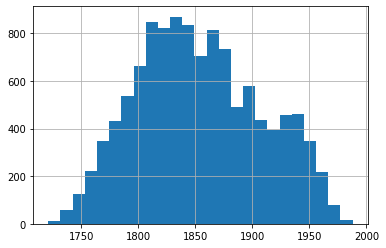

In [ ]:
legislators_historical['birth_year'].hist(bins=25)

In [ ]:
legislators_historical['birth_year'].value_counts()

1840    94
1824    94
1870    93
1828    92
1812    91
        ..
1987     1
1979     1
1730     1
1721     1
1982     1
Name: birth_year, Length: 262, dtype: Int64

Neither the histogram nor `value_counts` gave us any valuable information. We're going to have to group the data a bit. There are several options for this in pandas.
The first of these is the already known `.value_counts`, to which we can give the argument `bins`, which means that we do not want the frequencies of individual values, but that we want to group the data into several intervals.

In [ ]:
legislators_historical['birth_year'].value_counts(bins=10)

(1827.8, 1854.5]      2077
(1801.1, 1827.8]      1999
(1854.5, 1881.2]      1884
(1774.4, 1801.1]      1305
(1881.2, 1907.9]      1300
(1907.9, 1934.6]      1055
(1934.6, 1961.3]       962
(1747.7, 1774.4]       648
(1961.3, 1988.0]       162
(1720.732, 1747.7]     113
Name: birth_year, dtype: int64

What if such self-division is not enough for us? There is `pandas.cut`, resp. `pd.cut`. It has a lot of options, we recommend [go through the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

In [ ]:
bins = [1700, 1750, 1800, 1850, 1900, 1950]
pd.cut(legislators_historical['birth_year'], bins)

0        (1700.0, 1750.0]
1        (1700.0, 1750.0]
2        (1700.0, 1750.0]
3        (1700.0, 1750.0]
4        (1700.0, 1750.0]
               ...       
12050                 NaN
12051    (1900.0, 1950.0]
12052                 NaN
12053                 NaN
12054                 NaN
Name: birth_year, Length: 12055, dtype: category
Categories (5, interval[int64, right]): [(1700, 1750] < (1750, 1800] < (1800, 1850] < (1850, 1900] < (1900, 1950]]

In [ ]:
pd.cut(legislators_historical['birth_year'], bins).value_counts()

(1800, 1850]    3839
(1850, 1900]    3159
(1900, 1950]    2022
(1750, 1800]    1857
(1700, 1750]     149
Name: birth_year, dtype: int64

The disadvantage of `pd.cut` is that the intervals are user-defined and may take some time to debug. More automatic way is to specify intervals using a statistical distribution of data using `pd.qcut`. This function takes quantiles instead of interval boundaries.

In [ ]:
pd.qcut(legislators_historical['birth_year'], [0, .1, .5, .9, 1]).value_counts()

(1784.0, 1849.0]      4616
(1849.0, 1934.0]      4609
(1720.999, 1784.0]    1156
(1934.0, 1988.0]      1124
Name: birth_year, dtype: int64

Obviously we can use these transformed columns for aggregation again.  

**Task**: How many representatives there were and how many senators there were, divided according to the century in which they were born. (For example, between 1900 and 2000, 200 senators and 800 deputies were born, etc.)

### PivotTables
If we aggregate over several columns, it can happen that DataFrame becomes one long **noodle**. It is hard to find any meaning in it anymore.  If you have ever worked with such data in Excel, you may be familiar with the function of contingency tables, usually reffered as _pivot tables_.
Before we start pivoting, let's create a small dataset - it will be a simple aggregation based on the type of engagement from chamber and gender.

In [ ]:
summary = legislators_historical.groupby(['type', 'gender'], as_index=False)[['last_name']].count()
summary = summary.rename(columns={'last_name': 'count'})
summary

,type,gender,count
0,rep,F,214
1,rep,M,10001
2,sen,F,34
3,sen,M,1806


Each `pivot` includes three factors - specifications,
1. which columns we want in the index
2. which will be in the columns
3. which column is assigned to the values in the DataFrame
It's nice to see [in this diagram](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html).

In [ ]:
summary.pivot(index='gender', columns='type', values='count')

type,rep,sen
gender,,
F,214,34
M,10001,1806


A limitation of the `pivot` method is that it can only rotate a DataFrame, but if one of the fields matches multiple values, it throws you an error because it doesn't know how to aggregate them. The pivot is really just a turning around the data.
For more complex aggregations, there is a similarly named `pivot_table`.

In [ ]:
summary = legislators_historical.groupby(['type', 'state', 'gender'], as_index=False)[['last_name']].count()
summary = summary.rename(columns={'last_name': 'count'})
summary

,type,state,gender,count
0,rep,AK,M,11
1,rep,AL,F,2
2,rep,AL,M,167
3,rep,AR,F,3
4,rep,AR,M,81
...,...,...,...,...
169,sen,VT,M,36
170,sen,WA,M,20
171,sen,WI,M,26
172,sen,WV,M,31


`pivot_table` offers the ability to assign multiple columns to one of the dimensions (index or columns), and then create a multi-level index. It is also possible to specify which function is applied if there are multiple values per cell (as in Excel).
See [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) for more details.

In [ ]:
wide = summary.pivot_table(index='state', columns=['type', 'gender'], values='count', fill_value='')

wide.head(10)

type     rep         sen      
gender     F      M    F     M
state                         
AK             11.0        6.0
AL       2.0  167.0  2.0  38.0
AR       3.0   81.0  2.0  31.0
AS              2.0           
AZ       3.0   34.0  1.0  11.0
CA      24.0  301.0  2.0  41.0
CO       3.0   54.0       35.0
CT       6.0  183.0       51.0
DC              2.0           
DE             48.0       49.0

If you find it confusing that there are two similar functions on the pivot tables, we will confuse you even more, because there is still `pd.crosstab`. We will not go into details here, we recommend [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html).

### Inverse Context Tables
While many have come across contingency tables, their inverse functionality is quite unknown and interesting. It works exactly as we write - it takes a wide table in which one of the dimensions is in the columns, and narrows and lengthens by converting those column names into the column itself. The example will make it clearer.

In pandas, the `melt` method is used for this inverse operation. Its longer list of arguments is traditionally [in the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html).

Let's have a dataset where performance is measured in different regions of a fictitious country. The downside is that we can't look at time series completely, because the years to which the data applies are in columns, not rows. Such wide tables are quite popular, for example, for weather data ( ;) )

In [ ]:
df = pd.DataFrame({
    'region': ['North', 'South', 'East', 'West'],
    '2000': [200, 100, 50, 1000],
    '2005': [450, 10, 510, 1040],
    '2010': [10, 500, 950, 500],
    '2015': [550, 20, 50, 10],
    '2020': [1, 1, 5, 10],
})
df

,region,2000,2005,2010,2015,2020
0,North,200,450,10,550,1
1,South,100,10,500,20,1
2,East,50,510,950,50,5
3,West,1000,1040,500,10,10


`pd.melt` is interested in which of the columns somehow identifies the given rows (`id_vars`) and which columns contain values (`value_vars`). The other two arguments are only used to rename columns (`var_name`,` value_name`).

In [ ]:
long = df.melt(id_vars = ["region"], value_vars = ["2000", "2005", "2010", "2015", "2020"],var_name='year', value_name='output')

long

,region,year,output
0,North,2000,200
1,South,2000,100
2,East,2000,50
3,West,2000,1000
4,North,2005,450
5,South,2005,10
6,East,2005,510
7,West,2005,1040
8,North,2010,10
9,South,2010,500


**Task:** 
take this long dataset and make it into the original, wide one. (You don't have to deal with indexes apearing where there were none before).